In [1]:
import os, shutil
import flopy as fp
import numpy as np
import pyemu
import pandas as pd
import matplotlib.pyplot as plt
import pestools as pt
%matplotlib inline
# Quick check for Windows to make sure input files are Windows type
import platform
if 'window' in platform.platform().lower():
    ppp = 'pest++'
    newln='\n'
else:
    ppp='./pestpp'
    newln='\r\n'
    
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MultipleLocator


setting random seed


### Let's load up a couple arrays we will need for visualizing results

In [2]:
base_dir = os.path.join('..','..','models','Freyberg','Freyberg_pilotpoints')
[shutil.copy2(os.path.join(base_dir,cf),cf) for cf in os.listdir(base_dir)];
if not os.path.exists('base_pp_dir'):
    os.mkdir('base_pp_dir')
[shutil.copy2(os.path.join(base_dir,cf),os.path.join('base_pp_dir',cf)) for cf in os.listdir(base_dir)];


In [3]:
# Since this is a sythetic example, we can load up the true K field to compare our answers to 
HK_truth = np.loadtxt(os.path.join('..','..','models','Freyberg','Freyberg_Truth','hk.truth.ref'))
# ibound can be used to mask inactive areas
ib = np.loadtxt('ibound.ref')
HK_truth[ib==0] = np.nan
forecasts_true = pd.read_csv(os.path.join('..','..','models','Freyberg','Freyberg_Truth','forecasts_true.csv'), index_col=0)

In [4]:
forecasts_true

,true_mean
name,
FR03C16,19.58638
FR04C9,22.53065
RIVFLUX_FORE,-2685.39400
TRAVEL_TIME,40501.81000


# Set up a couple functions to help with displaying results

In [5]:
def update_K(inpstname):
    optpst = pyemu.Pst(inpstname + '.pst')
    # reset the parameter values using the best parameters from the last run
    optpst.parrep(inpstname + '.bpa')
    # set NOPTMAX=0 to run the model just a single time
    optpst.control_data.noptmax=0
    # write out the PST file with a new name
    optpst.write(inpstname + '_opt.pst')
    # run the new version of the model
    os.system('{0} {1}_opt.pst'.format(ppp, inpstname))

In [6]:
def plot_K_results(inpstname):
    HK_best = np.loadtxt('hk.ref')
    HK_best[ib==0] = np.nan
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(8,4))
    im1=ax1.imshow(HK_truth, interpolation='nearest', cmap='viridis', vmin = np.nanmin(HK_truth), vmax = np.nanmax(HK_truth))
    divider1 = make_axes_locatable(ax1)
    cax1 = divider1.append_axes("right", size="20%", pad=0.05)
    cbar1 = plt.colorbar(im1, cax=cax1,format="%.2f")

    im2=ax2.imshow(HK_best, interpolation='nearest', cmap='viridis', vmin = np.nanmin(HK_truth), vmax = np.nanmax(HK_truth))
    divider2 = make_axes_locatable(ax2)
    cax2 = divider2.append_axes("right", size="20%", pad=0.05)
    cbar2 = plt.colorbar(im2, cax=cax2,  format="%.2f")

    im3=ax3.imshow(HK_best, interpolation='nearest', cmap='viridis')
    divider3 = make_axes_locatable(ax3)
    cax3 = divider3.append_axes("right", size="20%", pad=0.05)
    cbar3 = plt.colorbar(im3, cax=cax3,  format="%.2f")
    plt.tight_layout()
    plt.savefig(inpstname + 'HK_.pdf')
    
    plt.figure()
    inphi = pd.read_csv(inpstname +'.iobj')
    inphi[['total_phi','measurement_phi', 'regularization_phi']].plot()
    plt.gca().set_yscale('log')
    plt.ylabel('PHI')
    plt.xlabel('Iteration Number')

In [7]:
def see_residuals(inpstname):
    res = pt.Res(inpstname + '.rei')
    print("HEAD FIT")
    print(res.describe_groups('head_cal'))
    print("FLUX FIT")
    print(res.describe_groups('flux_cal'))
    res.plot_one2one('head_cal',print_stats=['Mean', 'MAE', 'RMSE'])
    df_predu = pd.read_csv(inpstname + ".pred.usum.csv",index_col=0)
    df_predu = df_predu.join(forecasts_true)
    for forecast in df_predu.index:
        plt.figure()
        ax = df_predu.loc[forecast,["prior_mean","post_mean","true_mean"]].plot(kind="bar")
        ax.set_title(forecast)

## We will evaluate whether we overfit with noisy observations

In [8]:
# read in the pilot points PEST control file
inpst = pyemu.Pst('freyberg_pp_reg.pst')

In [9]:
# we can also read in some new head observations - these have more noise than we had before
noisy_heads = pd.read_csv(os.path.join('..','..','models','Freyberg',
                                       'Freyberg_Truth','really_noisy_heads.txt'),
                          index_col=0,
                          delim_whitespace=True)

In [10]:
# let's add more noise to both heads....
for i in noisy_heads.index:
    inpst.observation_data.set_value(i,'obsval', noisy_heads.loc[i]['really_noisy'])
# ... and flux observation as well
inpst.observation_data.set_value('rivflux_cal', 'obsval', -3200);

In [11]:
# values are getting a little more extreme - better crank outthe bounds too!
for i in inpst.parameter_data.index:
    if 'hk' in i:
        print(i)
        inpst.parameter_data.set_value(i,'parlbnd', 0.05)
        inpst.parameter_data.set_value(i,'parubnd', 130.0)
        
inpst.parameter_data

hkpp1
hkpp2
hkpp3
hkpp4
hkpp5
hkpp6
hkpp7
hkpp8
hkpp9
hkpp10
hkpp11
hkpp12
hkpp13
hkpp14
hkpp15
hkpp16
hkpp17
hkpp18
hkpp19
hkpp20
hkpp21
hkpp22
hkpp23
hkpp24
hkpp25
hkpp26
hkpp27
hkpp28
hkpp29
hkpp30
hkpp31
hkpp32
hkpp33
hkpp34
hkpp35
hkpp36
hkpp37
hkpp38
hkpp39
hkpp40
hkpp41
hkpp42
hkpp43
hkpp44
hkpp45
hkpp46
hkpp47
hkpp48
hkpp49
hkpp50
hkpp51
hkpp52
hkpp53
hkpp54
hkpp55
hkpp56
hkpp57
hkpp58
hkpp59
hkpp60
hkpp61
hkpp62
hkpp63
hkpp64
hkpp65
hkpp66
hkpp67
hkpp68
hkpp69
hkpp70


,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom
parnme,,,,,,,,,,
rch1,rch1,log,factor,0.000138,0.000079,0.000155,rch,1.0,0.0,1
rch2,rch2,fixed,factor,0.000094,0.000079,0.000155,rch,1.0,0.0,1
hkpp1,hkpp1,log,factor,8.000000,0.050000,130.000000,pilotpt,1.0,0.0,1
hkpp2,hkpp2,log,factor,8.000000,0.050000,130.000000,pilotpt,1.0,0.0,1
hkpp3,hkpp3,log,factor,8.000000,0.050000,130.000000,pilotpt,1.0,0.0,1
hkpp4,hkpp4,log,factor,8.000000,0.050000,130.000000,pilotpt,1.0,0.0,1
hkpp5,hkpp5,log,factor,8.000000,0.050000,130.000000,pilotpt,1.0,0.0,1
hkpp6,hkpp6,log,factor,8.000000,0.050000,130.000000,pilotpt,1.0,0.0,1
hkpp7,hkpp7,log,factor,8.000000,0.050000,130.000000,pilotpt,1.0,0.0,1


In [12]:
inpst.observation_data.head()

,obsnme,obsval,weight,obgnme
obsnme,,,,
cr03c16,cr03c16,21.6,1.0,head_cal
cr03c10,cr03c10,24.1,1.0,head_cal
cr04c9,cr04c9,24.5,1.0,head_cal
cr10c2,cr10c2,26.5,1.0,head_cal
cr14c11,cr14c11,20.3,1.0,head_cal


In [13]:
inpst.write('freyberg_pp_reg_noisy.pst')
shutil.copy2('freyberg_pp_reg_noisy.pst',os.path.join('base_pp_dir','freyberg_pp_reg_noisy.pst'))

'base_pp_dir/freyberg_pp_reg_noisy.pst'

# Pilot Points with Regularization controlled by `PHIMLIM`
There are a couple ways to control regularization in `pest++`. First we will cover using the variable `phimlim`

## First we can run without regularization (e.g. `PHIMLIM` is very low)

In [38]:
pyemu.utils.start_slaves('base_pp_dir',"{0}".format(ppp),"freyberg_pp_reg_noisy.pst",20,slave_root='.',port=4004,master_dir='.')

In [41]:
obfun = pd.read_csv('freyberg_pp_reg_noisy.iobj')
obfun

,iteration,model_runs_completed,total_phi,measurement_phi,regularization_phi,flux_fore,head_cal,flux_cal,travel_fore,head_fore,regulhkpp
0,0,0,108.784000,108.784000,0.000000e+00,0,59.860600,48.923000,0,0,0.000000e+00
1,1,80,17.125800,16.036900,1.088950e+00,0,14.220500,1.816380,0,0,1.088950e+00
2,2,102,4.951380,4.929070,2.230560e-02,0,4.928420,0.000657,0,0,2.230560e-02
3,3,138,3.375620,3.375380,2.449220e-04,0,3.374880,0.000492,0,0,2.449220e-04
4,4,174,3.350750,3.350750,2.186330e-06,0,3.350720,0.000032,0,0,2.186330e-06
5,5,324,3.016620,3.016620,4.406460e-08,0,3.016600,0.000013,0,0,4.406460e-08
6,6,360,2.524940,2.524940,4.637660e-08,0,2.524890,0.000046,0,0,4.637660e-08
7,7,395,2.200540,2.200540,4.827960e-08,0,2.200420,0.000121,0,0,4.827960e-08
8,8,431,2.001210,2.001210,4.976570e-08,0,2.001060,0.000152,0,0,4.976570e-08
9,9,578,1.247370,1.247370,6.417200e-08,0,0.777489,0.469883,0,0,6.417200e-08


HEAD FIT
                     Group summary
n                               13
Range                      0.68433
Max                         0.0583
Min                       -0.62603
Mean                     -0.109355
Standard deviation        0.205002
Varience                 0.0420257
25%                       -0.05188
50%                       -0.02425
75%                        0.00343
Max (absolute)             0.62603
Min (absolute)             0.00343
MAE                       0.122422
RMSE                      0.225281
RMSE/range                0.329199
Normally Distributed          True
p-value                0.000602463
FLUX FIT
                      Group summary
n                          1.000000
Range                      0.000000
Max                       -2.895000
Min                       -2.895000
Mean                      -2.895000
Standard deviation              NaN
Varience                        NaN
25%                       -2.895000
50%                       -2

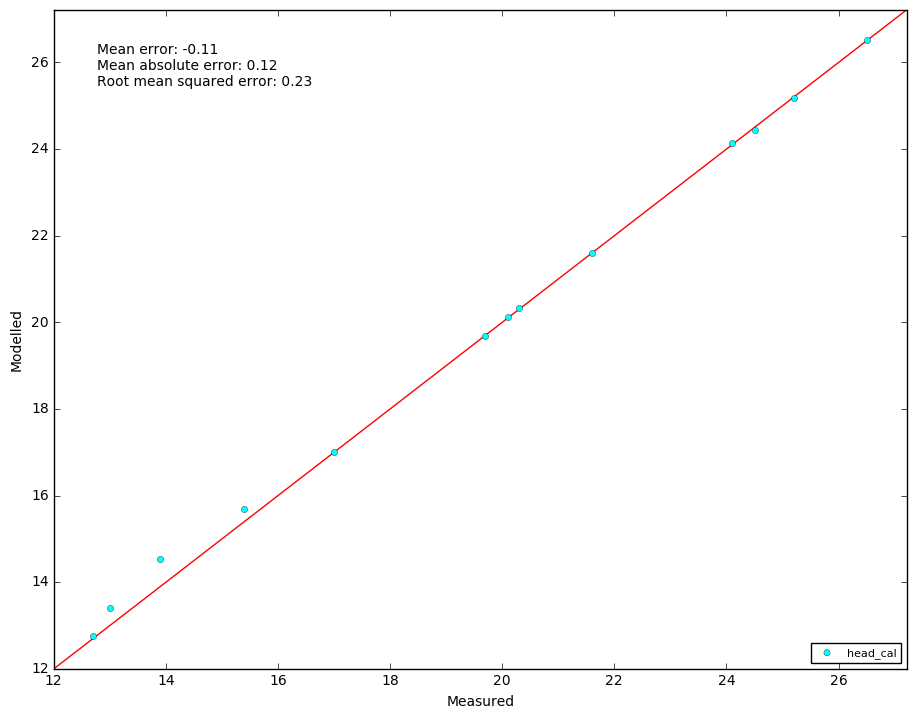

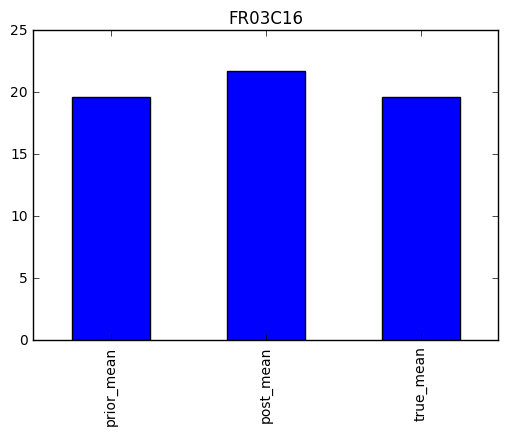

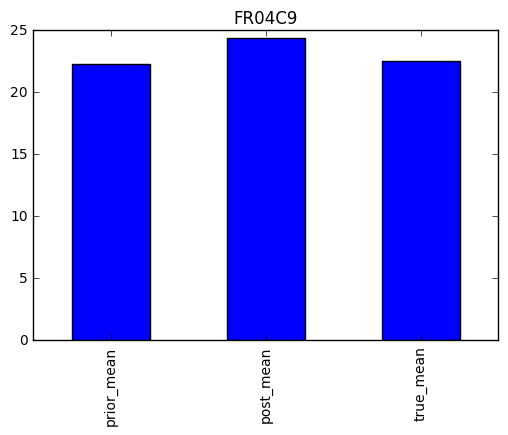

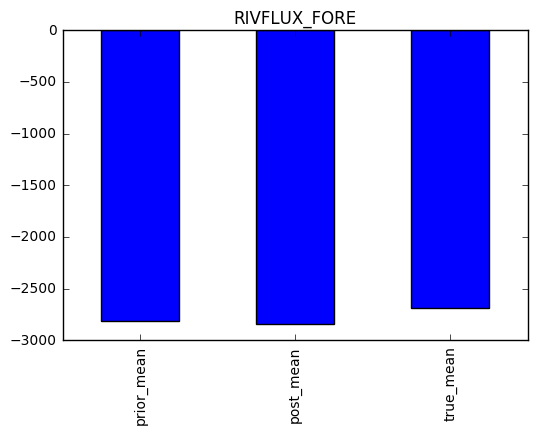

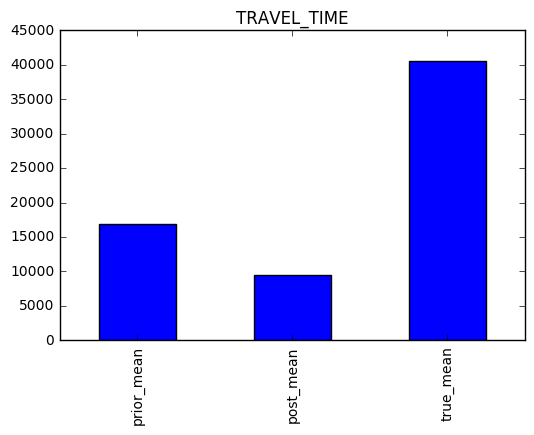

In [42]:
see_residuals('freyberg_pp_reg_noisy')

In [43]:
update_K('freyberg_pp_reg_noisy')

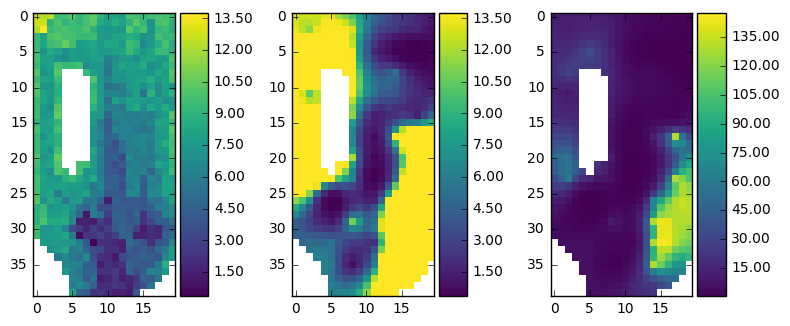

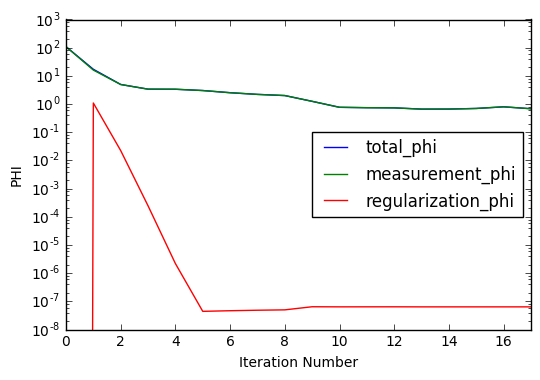

In [44]:
plot_K_results('freyberg_pp_reg_noisy')

In [23]:
update_K(phimlim14)

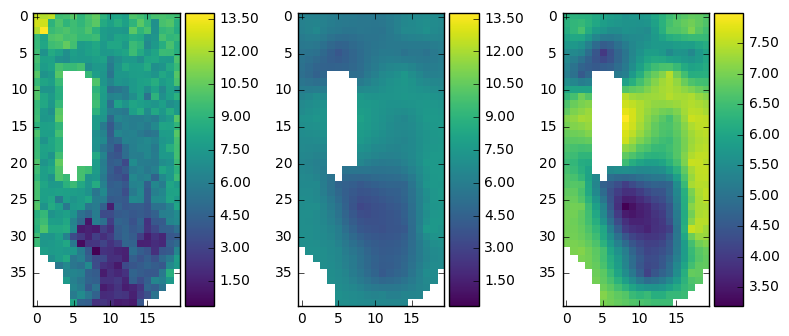

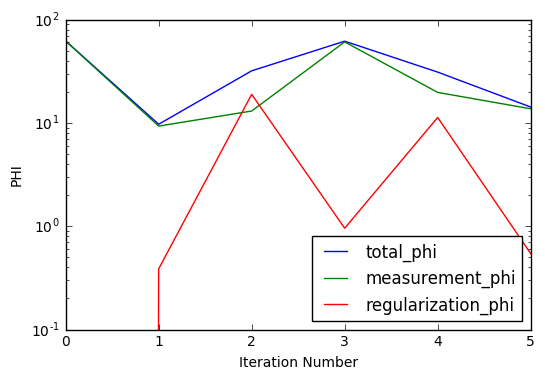

In [24]:
plot_K_results(phimlim14)